<a href="https://colab.research.google.com/github/pravin2909/variational-autoencoder-for-image-Generation/blob/main/variational_Autoencoder_for_medical_image_generation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install kagglehub


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import kagglehub

path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Path to dataset files:", path)


train_dir = os.path.join(path, "chest_xray/train")
test_dir = os.path.join(path, "chest_xray/test")
val_dir = os.path.join(path, "chest_xray/val")


class ChestXRayDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label in ['NORMAL', 'PNEUMONIA']:
            class_dir = os.path.join(data_dir, label)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.image_paths.append(img_path)
                self.labels.append(0 if label == 'NORMAL' else 1)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')  # Convert to grayscale
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),  # Converts to [0, 1]
])


train_dataset = ChestXRayDataset(train_dir, transform=transform)
test_dataset = ChestXRayDataset(test_dir, transform=transform)
val_dataset = ChestXRayDataset(val_dir, transform=transform)


batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


class VAE(nn.Module):
    def __init__(self, latent_dim=64):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 32 * 32, 256),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        self.decoder_fc = nn.Linear(latent_dim, 64 * 32 * 32)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_fc(z)
        h = h.view(-1, 64, 32, 32)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    reconstruction_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + kl_divergence


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE(latent_dim=64).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)



100%|██████████| 2.29G/2.29G [00:16<00:00, 148MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


Using device: cuda
Epoch [1/50], Loss: 367.2100
Epoch [2/50], Loss: 203.6416
Epoch [3/50], Loss: 180.5904
Epoch [4/50], Loss: 165.3860
Epoch [5/50], Loss: 152.4486
Epoch [6/50], Loss: 144.9510
Epoch [7/50], Loss: 138.5751
Epoch [8/50], Loss: 135.3055
Epoch [9/50], Loss: 131.6644
Epoch [10/50], Loss: 128.3382
Epoch [11/50], Loss: 126.0645
Epoch [12/50], Loss: 124.2123
Epoch [13/50], Loss: 123.9315
Epoch [14/50], Loss: 121.0945
Epoch [15/50], Loss: 119.7116
Epoch [16/50], Loss: 119.3308
Epoch [17/50], Loss: 118.1172
Epoch [18/50], Loss: 117.0659
Epoch [19/50], Loss: 116.3762
Epoch [20/50], Loss: 115.7599
Epoch [21/50], Loss: 115.0469
Epoch [22/50], Loss: 114.5695
Epoch [23/50], Loss: 113.8373
Epoch [24/50], Loss: 113.4519
Epoch [25/50], Loss: 112.9222
Epoch [26/50], Loss: 112.1555
Epoch [27/50], Loss: 112.2144
Epoch [28/50], Loss: 111.8428
Epoch [29/50], Loss: 111.3140
Epoch [30/50], Loss: 111.2138
Epoch [31/50], Loss: 110.3876
Epoch [32/50], Loss: 110.1270
Epoch [33/50], Loss: 110.2058


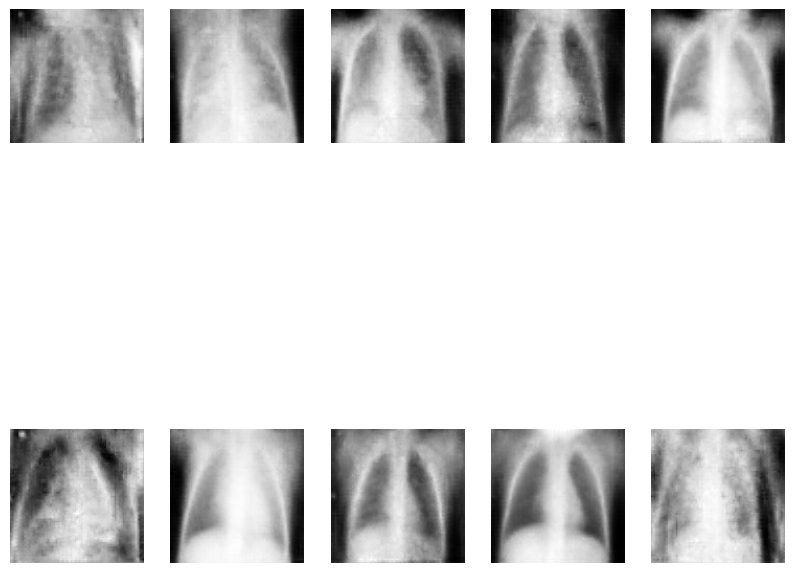

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Assuming VAE is already defined
# Define the model
latent_dim = 64  # Change according to your VAE architecture
vae = VAE(latent_dim=latent_dim).to(device)

# Define optimizer
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Training Loop
num_epochs = 50
for epoch in range(num_epochs):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):  # Ensure train_loader is defined
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = vae_loss(recon_batch, data, mu, logvar)  # Ensure vae_loss function is defined
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss / len(train_loader.dataset):.4f}")

# Image Generation Function
def generate_images(decoder, n_images=10, latent_dim=64):
    with torch.no_grad():
        random_latent_vectors = torch.randn(n_images, latent_dim).to(device)
        generated_images = decoder(random_latent_vectors).cpu()
    return generated_images

# Generate and display images
generated_images = generate_images(vae.decode, n_images=10)
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(generated_images[i].squeeze(), cmap="gray")
    plt.axis("off")
plt.show()


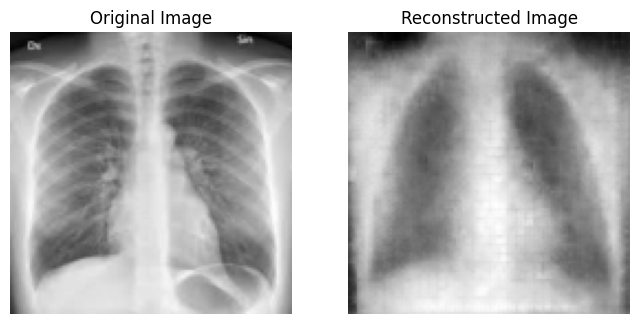

In [ ]:
# Load and preprocess the new image
new_image_path = "ty.jpeg"  # Replace with the path to your image
new_image = Image.open(new_image_path).convert('L')  # Convert to grayscale
new_image = transform(new_image)  # Apply the same transformations
new_image = new_image.unsqueeze(0).to(device)  # Add batch dimension and move to GPU if available

# Pass through the VAE
vae.eval()  # Set VAE to evaluation mode
with torch.no_grad():
    reconstructed_image, _, _ = vae(new_image)  # Get the reconstructed image

# Convert the output to a displayable format
reconstructed_image = reconstructed_image.squeeze(0).cpu().numpy()  # Remove batch dimension and move to CPU

# Plot original and reconstructed images side by side
# Plot original and reconstructed images side by side
plt.figure(figsize=(8, 4))

# Original Image
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(new_image.squeeze().cpu().numpy(), cmap="gray")  # Use .squeeze() to remove the extra dimension
plt.axis("off")

# Reconstructed Image
plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_image.squeeze(), cmap="gray")  # Ensure reconstructed image is also squeezed
plt.axis("off")

plt.show()



In [ ]:
# Save the trained model
torch.save(vae.state_dict(), "vae1_model.pth")
print("Model saved as 'vae1_model.pth'")


Model saved as 'vae1_model.pth'
